In [1]:
import h5py
import numpy as np
from scipy.signal import sosfiltfilt, butter
import matplotlib.pyplot as plt
import copy

In [22]:
filename = r"../data/offline_tests/session_25__set_1.h5"
with h5py.File(filename, "r") as h5f:
    print(h5f['data'].keys())
    eeg = h5f['data/EEG_f'][:]
    emg = h5f['data/EMG_f'][:]
    trigger = h5f['data/TRIG'][:]
eeg.shape, emg.shape, trigger.shape

<KeysViewHDF5 ['EEG_f', 'EMG_f', 'TRIG']>


((2308416, 64), (2308416, 1), (11542080, 1))

In [49]:
filename = r"../data/offline_tests/01_AV_M1_qp_45.hdf5"
with h5py.File(filename, "r") as h5f:
    print(h5f["eeg"].keys())
    data = h5f["eeg/data"][:-1]
data.shape

<KeysViewHDF5 ['blocks', 'data', 'streamInfo']>


(11542080, 67)

In [50]:
Fs = 25000 # Hz
start_idx, end_idx = 150000, 170000
ch = 65

In [59]:
bit = 0
trigger = np.array(data[:, -1])
ttl = np.array(data[:, -1], dtype=np.uint8)
trigger_bit = ((ttl>>bit) & 0b1).astype(int)

In [52]:
def find_events(trigger, up_front=True):
    """
    trigger: ndarray(int) - 0 or 1
    up_front: True if (event == from 0 to 1) else False 
    """
    trigger_d = np.diff(trigger)  # 1 if 0 -> 1; -1 if 1 -> 0
    target = 1 if up_front else -1
    return np.where(trigger_d == target)[0]

events = find_events(trigger, up_front=False)       # from 1 to 0 

In [9]:
signal = np.array(data[:, :-1], dtype=np.float32)

In [20]:
art_start_ms, art_end_ms = -0.04, 0.85
ms_to_sample = lambda ms: int(ms * Fs / 1000)
def interp_signal(signal, events, art_start, art_end):
    length = art_end - art_start
    ch = signal.shape[1]
    for event in events:
        before_sample = signal[event+art_start-1].reshape((-1, 1))
        after_sample = signal[event+art_end+1].reshape((-1, 1))
        new_value = np.concatenate([before_sample, after_sample], axis=1).mean(axis=1)
        interp_interval = np.array([np.full((length), interp_value) for interp_value in new_value]).T
        signal[event+art_start:event+art_end, :] = interp_interval
    return signal

signal_interp = interp_signal(copy.copy(signal), events, ms_to_sample(art_start_ms), ms_to_sample(art_end_ms))

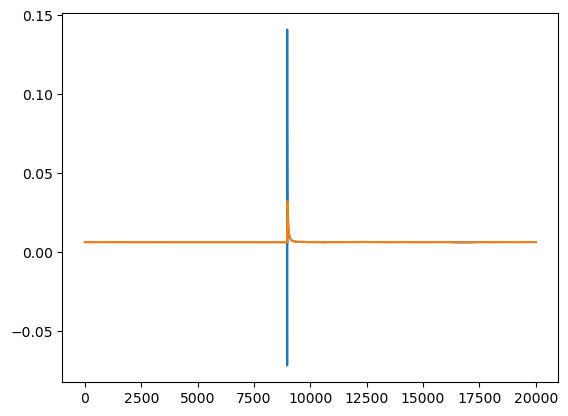

In [27]:
plt.plot(signal[start_idx:end_idx, ch]);
plt.plot(signal_interp[start_idx:end_idx, ch]);

In [29]:
high_freq = 2500 
sos = butter(N=4, Wn=high_freq, btype="lowpass", output='sos', fs=Fs)
data_filt = sosfiltfilt(np.ascontiguousarray(sos), signal_interp)

In [30]:
data_filt.shape

(11542080, 66)

In [66]:
factor = 5
data_resample = data_filt[::factor]
trigger_resample = trigger[::factor].reshape((-1, 1))

In [67]:
data_resample.shape, trigger_resample.shape

((2308416, 66), (2308416, 1))

In [68]:
data_new = np.concatenate([data_resample, trigger_resample], axis=1)
data_new.shape

(2308416, 67)

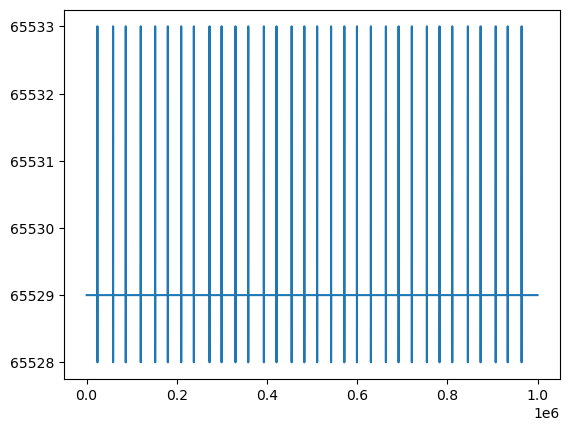

In [69]:
start_point = 200000
end_point = 1200000
plt.plot(trigger_resample[start_point:end_point])

In [70]:
data2save = data_new[start_point:end_point]
filename_output = r"..\data\offline_tests\AV_75triplets_5kHz.h5"
with h5py.File(filename_output, "w") as h5f:
    h5f.create_dataset("data", data=data2save)